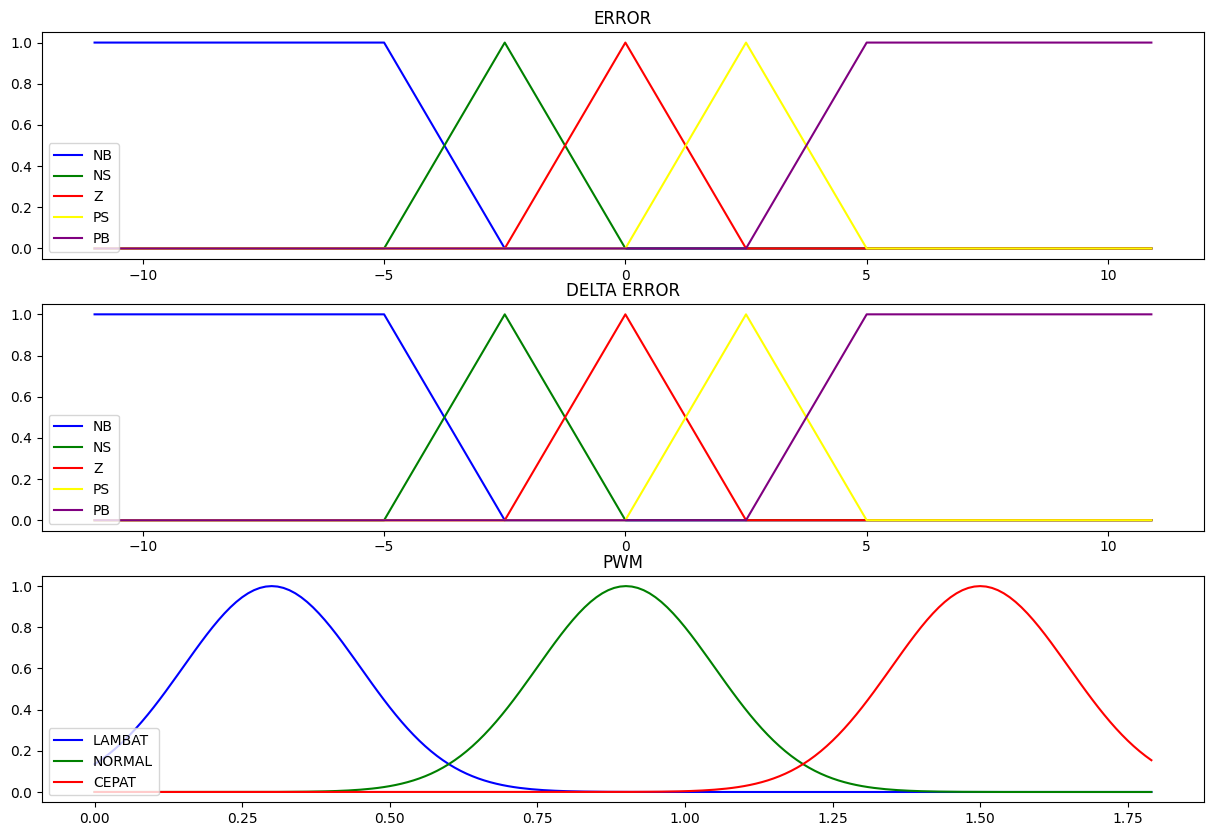

In [552]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
x_error = np.arange(-11, 11, 0.1)
x_dError = np.arange(-11, 11, 0.1)
x_pwm = np.arange(0, 1.8, 0.01)

    # Definisi fungsi keanggotaan untuk error dan deltaError
e_NB = fuzz.trapmf(x_error, [-11, -11, -5, -2.5])
e_NS = fuzz.trimf(x_error, [-5, -2.5, 0])
e_Z = fuzz.trimf(x_error, [-2.5, 0, 2.5])
e_PS = fuzz.trimf(x_error, [0, 2.5, 5])
e_PB = fuzz.trapmf(x_error, [2.5, 5, 11, 11])

dE_NB = fuzz.trapmf(x_dError, [-11, -11, -5, -2.5])
dE_NS = fuzz.trimf(x_dError, [-5, -2.5, 0])
dE_Z = fuzz.trimf(x_dError, [-2.5, 0, 2.5])
dE_PS = fuzz.trimf(x_dError, [0, 2.5, 5])
dE_PB = fuzz.trapmf(x_dError, [2.5, 5, 11, 11])

    # Definisi fungsi keanggotaan untuk output PWM
pwm_lambat = fuzz.gaussmf(x_pwm, 0.3, 0.15)
pwm_normal = fuzz.gaussmf(x_pwm, 0.9, 0.15)
pwm_cepat = fuzz.gaussmf(x_pwm, 1.5, 0.15)

fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3 , figsize=(15, 10))

ax1.plot(x_error, e_NB, 'b', linewidth=1.5, label='NB')
ax1.plot(x_error, e_NS, 'g', linewidth=1.5, label='NS')
ax1.plot(x_error, e_Z, 'r', linewidth=1.5, label='Z')
ax1.plot(x_error, e_PS, 'yellow', linewidth=1.5, label='PS')
ax1.plot(x_error, e_PB, 'purple', linewidth=1.5, label='PB')
ax1.set_title('ERROR')
ax1.legend(loc = 3)

ax2.plot(x_dError, dE_NB, 'b', linewidth=1.5, label='NB')
ax2.plot(x_dError, dE_NS, 'g', linewidth=1.5, label='NS')
ax2.plot(x_dError, dE_Z, 'r', linewidth=1.5, label='Z')
ax2.plot(x_dError, dE_PS, 'yellow', linewidth=1.5, label='PS')
ax2.plot(x_dError, dE_PB, 'purple', linewidth=1.5, label='PB')
ax2.set_title('DELTA ERROR')
ax2.legend(loc = 3)

ax3.plot(x_pwm, pwm_lambat, 'b', linewidth=1.5, label='LAMBAT')
ax3.plot(x_pwm, pwm_normal, 'g', linewidth=1.5, label='NORMAL')
ax3.plot(x_pwm, pwm_cepat, 'r', linewidth=1.5, label='CEPAT')
ax3.set_title('PWM')
ax3.legend(loc = 3)


error = -6
dError = 0

e_lvl_NB = fuzz.interp_membership(x_error, e_NB,error)
e_lvl_NS = fuzz.interp_membership(x_error, e_NS,error)
e_lvl_Z = fuzz.interp_membership(x_error, e_Z,error)
e_lvl_PS = fuzz.interp_membership(x_error, e_PS,error)
e_lvl_PB = fuzz.interp_membership(x_error, e_PB,error)

dE_lvl_NB = fuzz.interp_membership(x_dError, dE_NB,dError)
dE_lvl_NS = fuzz.interp_membership(x_dError, dE_NS,dError)
dE_lvl_Z = fuzz.interp_membership(x_dError, dE_Z,dError)
dE_lvl_PS = fuzz.interp_membership(x_dError, dE_PS,dError)
dE_lvl_PB = fuzz.interp_membership(x_dError, dE_PB,dError)

rule1 = np.fmin(e_lvl_NB, dE_lvl_NB)#low
rule2 = np.fmin(e_lvl_NB, dE_lvl_NS)#low
rule3 = np.fmin(e_lvl_NB, dE_lvl_Z)#low
rule4 = np.fmin(e_lvl_NB, dE_lvl_PS)#low
rule5 = np.fmin(e_lvl_NB, dE_lvl_PB)#normal
rule6 = np.fmin(e_lvl_NS, dE_lvl_NB)#low
rule7 = np.fmin(e_lvl_NS, dE_lvl_NS)#low
rule8 = np.fmin(e_lvl_NS, dE_lvl_Z)#low
rule9 = np.fmin(e_lvl_NS, dE_lvl_PS)#normal
rule10 = np.fmin(e_lvl_NS, dE_lvl_PB)#fast
rule11 = np.fmin(e_lvl_Z, dE_lvl_NB)#low
rule12 = np.fmin(e_lvl_Z, dE_lvl_NS)#low
rule13 = np.fmin(e_lvl_Z, dE_lvl_Z)#normal
rule14 = np.fmin(e_lvl_Z, dE_lvl_PS)#fast
rule15 = np.fmin(e_lvl_Z, dE_lvl_PB)#fast
rule16 = np.fmin(e_lvl_PS, dE_lvl_NB)#low
rule17 = np.fmin(e_lvl_PS, dE_lvl_NS)#normal
rule18 = np.fmin(e_lvl_PS, dE_lvl_Z)#fast
rule19 = np.fmin(e_lvl_PS, dE_lvl_PS)#fast
rule20 = np.fmin(e_lvl_PS, dE_lvl_PB)#fast
rule21 = np.fmin(e_lvl_PB, dE_lvl_PB)#normal
rule22 = np.fmin(e_lvl_PB, dE_lvl_PB)#fast
rule23 = np.fmin(e_lvl_PB, dE_lvl_PB)#fast
rule24 = np.fmin(e_lvl_PB, dE_lvl_PB)#fast
rule25 = np.fmin(e_lvl_PB, dE_lvl_PB)#fast

gabungan_lambat = np.fmax(rule1,np.fmax(rule2,np.fmax(rule3,np.fmax(rule4,np.fmax(rule6,np.fmax(rule7,np.fmax(rule8,np.fmax(rule11,np.fmax(rule12,rule16))))))))) 
gabungan_normal =  np.fmax(rule5,np.fmax(rule9,np.fmax(rule13,np.fmax(rule17,rule21))))
gabungan_cepat = np.fmax(rule10,np.fmax(rule14,np.fmax(rule15,np.fmax(rule18,np.fmax(rule19,np.fmax(rule20,np.fmax(rule22,np.fmax(rule23,np.fmax(rule24,rule25))))))))) 


hasil_lambat = np.fmin(gabungan_lambat,pwm_lambat)
hasil_normal = np.fmin(gabungan_normal,pwm_normal)
hasil_cepat = np.fmin(gabungan_cepat,pwm_cepat)

aggregated = np.fmax(hasil_lambat,np.fmax(hasil_normal,hasil_cepat))
pwm = fuzz.defuzz(x_pwm, aggregated, 'centroid')

hasil_vic = fuzz.interp_membership(x_pwm, aggregated, pwm)

hasil = np.zeros_like(x_pwm)

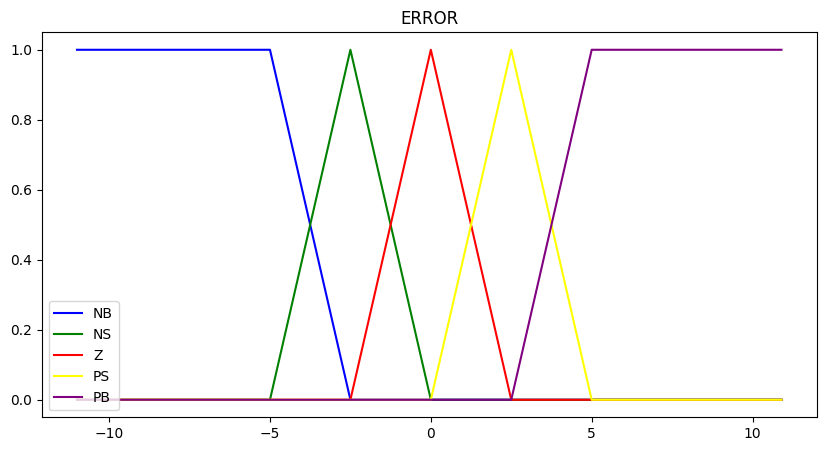

In [553]:
fig, (ax1) = plt.subplots(nrows = 1 , figsize=(10, 5))

ax1.plot(x_error, e_NB, 'b', linewidth=1.5, label='NB')
ax1.plot(x_error, e_NS, 'g', linewidth=1.5, label='NS')
ax1.plot(x_error, e_Z, 'r', linewidth=1.5, label='Z')
ax1.plot(x_error, e_PS, 'yellow', linewidth=1.5, label='PS')
ax1.plot(x_error, e_PB, 'purple', linewidth=1.5, label='PB')
ax1.set_title('ERROR')
ax1.legend(loc = 3)

In [554]:
pwm

0.30830286693107084

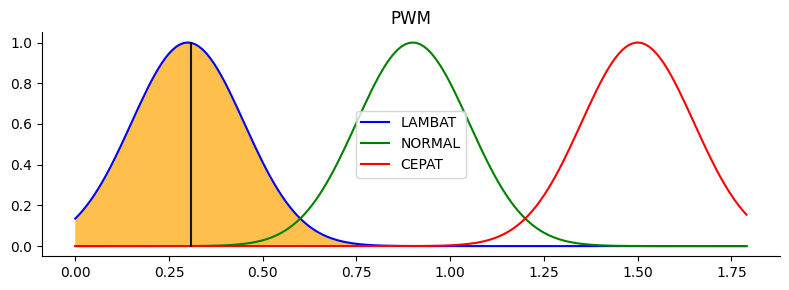

In [555]:
fig, ax2 = plt.subplots(figsize=(8, 3))
ax2.plot(x_pwm, pwm_lambat, 'b', linewidth=1.5, label='LAMBAT')
ax2.plot(x_pwm, pwm_normal, 'g', linewidth=1.5, label='NORMAL')
ax2.plot(x_pwm, pwm_cepat, 'r', linewidth=1.5, label='CEPAT')
ax2.plot([pwm, pwm], [0, hasil_vic], 'k', linewidth=1.5, alpha=0.9)
ax2.fill_between(x_pwm, aggregated, facecolor='Orange', alpha=0.7)
ax2.set_title('PWM')    

# Turn off top/right axes
for ax in (ax2,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.legend()

In [556]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Nama file CSV yang akan dibaca
csv_file_name = 'data_simulasi.csv'

# Baca data dari file CSV menggunakan pandas
data = pd.read_csv(csv_file_name)


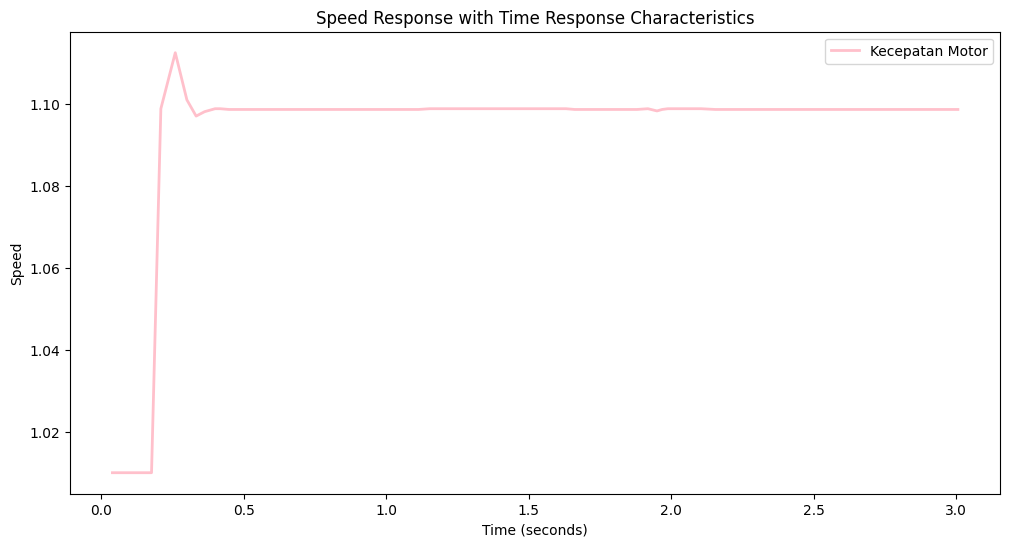

In [557]:

plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['SpeedMotor'],color= 'pink', label='Kecepatan Motor', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Speed')
plt.title('Speed Response with Time Response Characteristics')
plt.grid(False)
plt.legend()

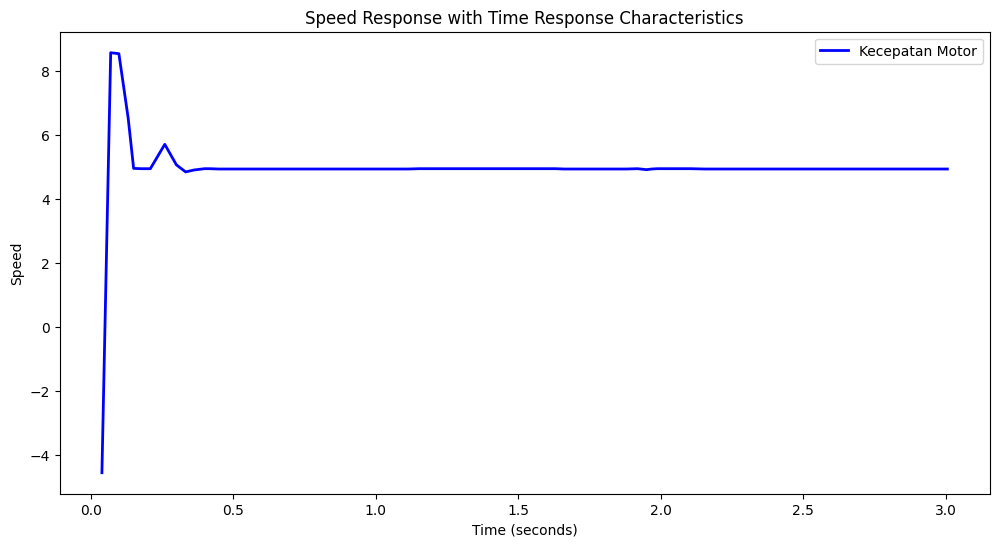

In [558]:
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['SensorAccelerometer'],color= 'blue', label='Kecepatan Motor', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Speed')
plt.title('Speed Response with Time Response Characteristics')
plt.grid(False)
plt.legend()

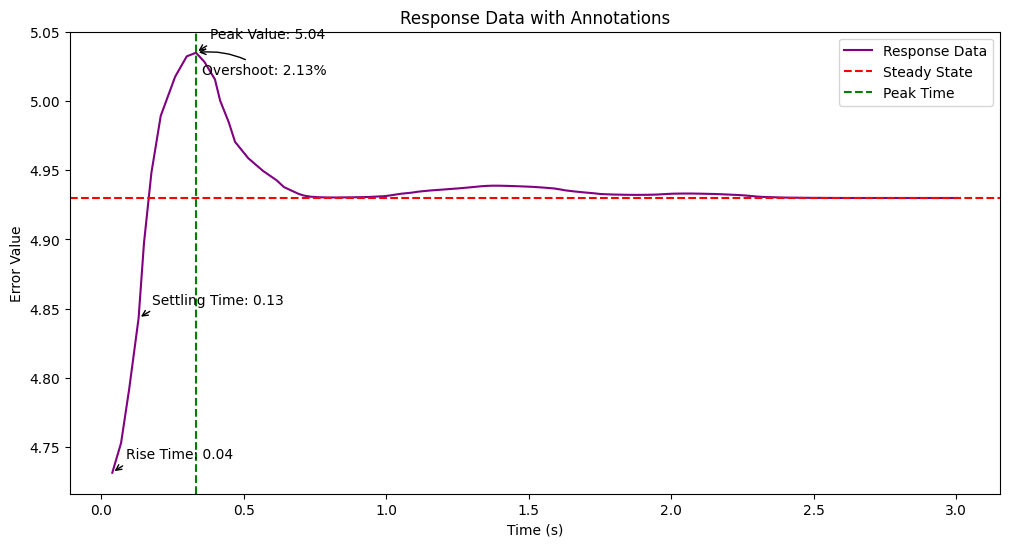

Steady State Value: 4.93
Peak Time: 0.33
Peak Value: 5.04
Overshoot (%): 2.13
Rise Time: 0.04
Settling Time: 0.13
Undershoot (%): None


In [559]:
sigma = 5 #filter gausian
smoothed_speed_data = gaussian_filter1d(data['ErrorValue'], sigma)

time = data['Time'].values
response = smoothed_speed_data  # Ganti 'SensorValue' dengan nama kolom data respons Anda


def annotate_plot(ax, time, data, text):
    for t, d in zip(time, data):
        ax.annotate(text, xy=(t, d), xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))


def plot_data_with_annotations(time, response): # 
    global steady_state_value, peak_time, peak_value, overshoot, rise_time, settling_time, undershoot
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(time, response, label='Response Data',color='purple')

    steady_state_value = np.mean(response[-10:])
    ax.axhline(y=steady_state_value, color='r', linestyle='--', label='Steady State')

    peaks, _ = find_peaks(response)
    peak_time = time[peaks][0] if peaks.size > 0 else None
    if peak_time is not None:
        ax.axvline(x=peak_time, color='g', linestyle='--', label='Peak Time')

    if peak_time is not None:
        peak_value = response[peaks][0]
        annotate_plot(ax, [peak_time], [peak_value], f'Peak Value: {peak_value:.2f}')

    rise_time_index = np.where(response >= 0.9 * steady_state_value)[0][0] if np.any(response >= 0.9 * steady_state_value)  else None
    if rise_time_index is not None:
        rise_time = time[rise_time_index]
        annotate_plot(ax, [rise_time], [response[rise_time_index]], f'Rise Time: {rise_time:.2f}')

    settling_index = np.where(np.abs(response - steady_state_value) <= 0.02 * steady_state_value)[0]
    settling_time = time[settling_index[0]] if settling_index.size > 0 else None 
    if settling_time:
        annotate_plot(ax, [settling_time], [response[settling_index[0]]], f'Settling Time: {settling_time:.2f}')

    overshoot = ((peak_value - steady_state_value) / steady_state_value) * 100 if peak_value is not None else None
    if overshoot is not None:
        if overshoot <= 0:
            overshoot= abs(overshoot)
        overshoot_text = f'Overshoot: {overshoot:.2f}%'
        ax.annotate(overshoot_text, xy=(peak_time, peak_value), xytext=(peak_time + 0.02, peak_value - 0.0158),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    undershoot = None
    if np.any(response < 0):
        if overshoot <= 0:
            undershoot_value = np.min(response)
            undershoot = ((steady_state_value - undershoot_value) / steady_state_value) * 100 if undershoot_value is not None else None
    if undershoot is not None:
        annotate_plot(ax, [peak_time], [peak_value], f'Undershoot: {undershoot:.2f}%')

    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Error Value')
    ax.set_title('Response Data with Annotations')
    ax.grid(False)

    plt.show()
    return {
        'Steady State Value': steady_state_value,
        'Peak Time': peak_time,
        'Peak Value': peak_value,
        'Overshoot (%)': overshoot,
        'Rise Time': rise_time,
        'Settling Time': settling_time,
        'Undershoot (%)': undershoot
    }

# Jalankan fungsi plot dan cetak metrik
metrics = plot_data_with_annotations(time, response)
if metrics:
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: None")


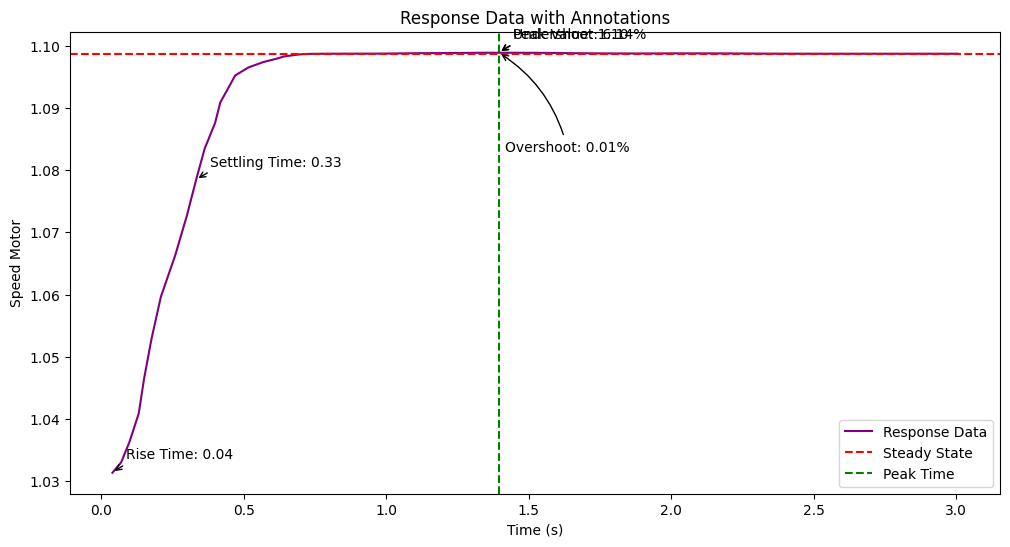

Steady State Value: 1.10
Peak Time: 1.39
Peak Value: 1.10
Overshoot (%): 0.01
Rise Time: 0.04
Settling Time: 0.33
Undershoot (%): 6.14


In [560]:
sigma = 5 #filter gausian
smoothed_speed_data = gaussian_filter1d(data['SpeedMotor'], sigma)

time = data['Time'].values
response = smoothed_speed_data  # Ganti 'SensorValue' dengan nama kolom data respons Anda


def annotate_plot(ax, time, data, text):
    for t, d in zip(time, data):
        ax.annotate(text, xy=(t, d), xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Fungsi untuk membuat plot dengan garis bantu dan anotasi
def plot_data_with_annotations(time, response): # 
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(time, response, label='Response Data',color='purple')

    steady_state_value = np.mean(response[-10:])
    ax.axhline(y=steady_state_value, color='r', linestyle='--', label='Steady State')

    peaks, _ = find_peaks(response)
    peak_time = time[peaks][0] if peaks.size > 0 else None
    if peak_time is not None:
        ax.axvline(x=peak_time, color='g', linestyle='--', label='Peak Time')

    if peak_time is not None:
        peak_value = response[peaks][0]
        annotate_plot(ax, [peak_time], [peak_value], f'Peak Value: {peak_value:.2f}')

    rise_time_index = np.where(response >= 0.9 * steady_state_value)[0][0] if np.any(response >= 0.9 * steady_state_value) else None
    if rise_time_index is not None:
        rise_time = time[rise_time_index]
        annotate_plot(ax, [rise_time], [response[rise_time_index]], f'Rise Time: {rise_time:.2f}')

    settling_index = np.where(np.abs(response - steady_state_value) <= 0.02 * steady_state_value)[0]
    settling_time = time[settling_index[0]] if settling_index.size > 0 else None
    if settling_time:
        annotate_plot(ax, [settling_time], [response[settling_index[0]]], f'Settling Time: {settling_time:.2f}')

    overshoot = ((peak_value - steady_state_value) / steady_state_value) * 100 if peak_value is not None else None
    if overshoot <= 0:
        overshoot = None
    if overshoot is not None:
        overshoot_text = f'Overshoot: {overshoot:.2f}%'
        ax.annotate(overshoot_text, xy=(peak_time, peak_value), xytext=(peak_time + 0.02, peak_value - 0.0158),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    # undershoot = None

    undershoot_value = np.min(response)
    undershoot = ((steady_state_value - undershoot_value) / steady_state_value) * 100 if undershoot_value is not None else None
    if undershoot:
        annotate_plot(ax, [peak_time], [peak_value], f'Undershoot: {undershoot:.2f}%')

    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Speed Motor')
    ax.set_title('Response Data with Annotations')
    ax.grid(False)

    plt.show()
    return {
        'Steady State Value': steady_state_value,
        'Peak Time': peak_time,
        'Peak Value': peak_value,
        'Overshoot (%)': overshoot,
        'Rise Time': rise_time,
        'Settling Time': settling_time,
        'Undershoot (%)': undershoot
    }

# Jalankan fungsi plot dan cetak metrik
metrics = plot_data_with_annotations(time, response)
if metrics:
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: None")

In [561]:
#     #Plot data yang sudah difilter dan diolah
# peaks, _ = find_peaks(smoothed_speed_data)  
# peak_time = time_step[peaks[0]] if peaks.size > 0 else None
# peak_value = smoothed_speed_data[peaks[0]] if peaks.size > 0 else None
# steady_state_value = smoothed_speed_data[-1]
# time_10 = np.interp(0.1 * steady_state_value, smoothed_speed_data, time_step)
# time_90 = np.interp(0.9 * steady_state_value, smoothed_speed_data, time_step)
# rise_time = time_90 - time_10 if time_10 and time_90 else None
# overshoot = ((peak_value - steady_state_value) / steady_state_value) * 100 if peak_value and steady_state_value else None
# settling_indices = np.where(np.abs(smoothed_speed_data - steady_state_value) <= 0.02 * steady_state_value)[0]
# settling_time = time_step[settling_indices[0]] if settling_indices.size > 0 else None
# plt.figure(figsize=(12, 6))
# plt.plot(time_step, smoothed_speed_data, color= 'red',label='Kecepatan Motor diolah', linewidth=2)
# plt.xlabel('Time (seconds)')
# plt.ylabel('Speed')
# plt.title('Speed Response with Time Response Characteristics')
# # Annotate steady state value
# plt.annotate(f'Steady State Value: {steady_state_value:.2f}', 
#             xy=(time_step[-1], steady_state_value), 
#             xytext=(time_step[-1]- 1, steady_state_value + 0.01),
#             arrowprops=dict(facecolor='black', arrowstyle='->'))
# # Annotate peak time and peak value
# if peak_time and peak_value:
#     plt.plot(peak_time, peak_value, 'ro', label=f'peak time: {peak_time:.2f}')  # Mark the peak point
#     plt.plot(peak_time, peak_value, 'ro', label=f'peak Value: {peak_value:.2f}')  # Mark the peak point
#     plt.annotate(f'Peak Time: {peak_time:.2f}s\nPeak Value: {peak_value:.2f}', 
#                 xy=(peak_time, peak_value), 
#                 xytext=(peak_time + 0.01, peak_value+ 0.01),
#                 arrowprops=dict(facecolor='black', arrowstyle='->'))
# # Annotate rise time
# # if rise_time:
# #     plt.axvline(x=rise_time, color='pink', linestyle='--', label=f'Rise Time: {rise_time:.2f}s')
# #     plt.annotate(f'Rise Time: {rise_time:.2f}s', 
# #                  xy=(rise_time, steady_state_value), 
# #                  xytext=(rise_time, steady_state_value + 0.01),
# #                  arrowprops=dict(facecolor='black', arrowstyle='->'))
# # Annotate settling time
# if settling_time:
#     plt.axvline(x=settling_time, color='green', linestyle='--', label=f'Settling Time: {settling_time:.2f}s')
#     plt.annotate(f'Settling Time: {settling_time:.2f}s', 
#                 xy=(settling_time, steady_state_value), 
#                 xytext=(settling_time, steady_state_value),
#                 arrowprops=dict(facecolor='black', arrowstyle='->'))
# # if overshoot:
# plt.annotate(f'Defuzzifikasi: {overshoot:.2f}%', 
#              xy=(peak_time, peak_value), 
#              xytext=(peak_time + 1, peak_value - 0.1),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.grid(True)
# plt.legend()
# plt.show()